# Applying Forward propagation, Backward propagation and Gradient checking using different optimizers from scratch to better understand how Neural Networks work.

In [1]:
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading the data.
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.shape)
X = data[:, :5]
y = data[:, -1]
print(X.shape, y.shape)

(506, 6)
(506, 5) (506,)


## Computational graph

<img src='https://i.imgur.com/seSGbNS.png'>

If you observe the graph, we are having input features [f1,f2,f3,f4,f5] and 9 weights [w1,w2,w3,w4,w5,w6,w7,w8,w9].

The final output of this graph is a value L which is computed as (Y-Y')^2 

### For easy debugging, we will break the computational graph into 3 parts.

Part 1

<img src='https://i.imgur.com/0xUaxy6.png'>

Part 2

<img src='https://i.imgur.com/J29pAJL.png'>

Part 3

<img src='https://i.imgur.com/vMyCsd9.png'>

## Forward propagation

In [2]:
# This function calculates the sigmoid(z).
def sigmoid(z):
    # We can use this function in forward and backward propagation
    sig=1/(1+np.exp(-z))
    return sig

In [3]:
# This function will compute forward propagation.
def forward_propagation(x, y, w):

    # X: input data point, note that in this assignment you are having 5-d data points.
    # y: output varible
    # W: weight array, its of length 9, W[0] corresponds to w1 in graph and W[8] corresponds to w9 in graph.
    # Computing the values in parts as per the flowchart.
    
    val_1= (w[0]*x[0]+w[1]*x[1]) * (w[0]*x[0]+w[1]*x[1]) + w[5]
    part_1 = np.exp(val_1)
    part_2 = np.tanh(part_1 + w[6])
    v1 = np.sin(w[2] * x[2])
    v2 = (w[3] * x[3]) + (w[4] * x[4])
    part_3 = sigmoid((v1 * v2) + w[7]) 
        
    # After computing part1, part2 and part3 computing the value of y' from the main Computational graph using required equations
    # Computing the value of L=(y-y')^2 and store it in variable loss.
    # Computing the derivative of L w.r.to y' and store it in dy_pred. 
    # Creating a dictionary to store all the intermediate values i.e. dy_pred, loss, exp, tanh, sigmoid.

    y_pred = part_2 + (part_3 * w[8])
    loss = (y - y_pred) * (y - y_pred)
    dy_pred = -2 * (y - y_pred)
        
    forward_dict={}
    forward_dict['exp']= part_1
    forward_dict['sigmoid'] = part_3
    forward_dict['tanh'] = part_2
    forward_dict['loss'] = loss
    forward_dict['dy_pred'] = dy_pred
    forward_dict['v1'] = v1
    forward_dict['v2'] = v2
    forward_dict['part_3'] = part_3
    # We will be using the dictionary to find values in backpropagation, you can add other keys in dictionary as well.

    return forward_dict

## Backward propagation

In [4]:
# This function will compute backward propagation.
def backward_propagation(x,y,w,forward_dict):
    
    # forward_dict: the outputs of the forward_propagation() function.
    # Computing the gradients of each weight [w1,w2,w3,w4,w5,w6,w7,w8,w9].

    exp = forward_dict['exp']
    sig = forward_dict['sigmoid']
    tan = forward_dict['tanh']
    dy_pred = forward_dict['dy_pred']
    v1 = forward_dict['v1']
    v2 = forward_dict['v2']
    part_3 = forward_dict['part_3']
    dw1 = dy_pred * (1 - (tan*tan)) * exp * (2*(w[0]*x[0] + w[1]*x[1])*x[0])
    dw2 = dy_pred * (1 - (tan*tan)) * exp * (2*(w[0]*x[0] + w[1]*x[1])*x[1])
    dw3 = dy_pred * w[8]* sig*(1-sig) * np.cos(w[2]*x[2])*x[2] * v2 
    dw4 = dy_pred * w[8]* sig*(1-sig) * v1 * x[3]
    dw5 = dy_pred * w[8]* sig*(1-sig) * v1 * x[4]
    dw6 = dy_pred * (1 - (tan*tan)) * exp
    dw7 = dy_pred * (1 - (tan*tan))
    dw8 = dy_pred * w[8]* sig*(1-sig)
    dw9 = dy_pred * part_3
    
    # Storing the variables in a dict as backward_dict.
    backward_dict={}
    backward_dict['dw1']=dw1
    backward_dict['dw2']=dw2
    backward_dict['dw3']=dw3
    backward_dict['dw4']=dw4
    backward_dict['dw5']=dw5
    backward_dict['dw6']=dw6
    backward_dict['dw7']=dw7
    backward_dict['dw8']=dw8
    backward_dict['dw9']=dw9
    
    #print(dw1,dw2,dw3,dw4,dw5,dw6,dw7,dw8,dw9)    
    
    return backward_dict

 ## Gradient clipping

<b> Check this  <a href='https://towardsdatascience.com/how-to-debug-a-neural-network-with-gradient-checking-41deec0357a9'>blog link</a> for more details on Gradient clipping

## Gradient checking example

Let's understand the concept with a simple example:
$f(w1,w2,x1,x2)=w_{1}^{2} . x_{1} + w_{2} . x_{2}$ 

From the above function, lets assume $w_{1}=1$, $w_{2}=2$, $x_{1}=3$, $x_{2}=4$ the gradient of $f$ w.r.t $w_{1}$ is

\begin{array} {lcl}
\frac{df}{dw_{1}} = dw_{1} &=&2.w_{1}.x_{1} \\& = &2.1.3\\& = &6
\end{array}


Let's calculate the aproximate gradient of $w_{1}$ as mentinoned in the above formula and considering $\epsilon=0.0001$

\begin{array} {lcl}
dw_1^{approx} & = & \frac{f(w1+\epsilon,w2,x1,x2)-f(w1-\epsilon,w2,x1,x2)}{2\epsilon} \\ & = & \frac{((1+0.0001)^{2} . 3 + 2 . 4) - ((1-0.0001)^{2} . 3 + 2 . 4)}{2\epsilon} \\ & = & \frac{(1.00020001 . 3 + 2 . 4) - (0.99980001. 3 + 2 . 4)}{2*0.0001} \\ & = & \frac{(11.00060003) - (10.99940003)}{0.0002}\\ & = & 5.99999999999
\end{array}

Then, we apply the following formula for gradient check: <i>gradient_check</i> = 
$\frac{\left\Vert\left (dW-dW^{approx}\rm\right) \right\Vert_2}{\left\Vert\left (dW\rm\right) \right\Vert_2+\left\Vert\left (dW^{approx}\rm\right) \right\Vert_2}$

The equation above is basically the Euclidean distance normalized by the sum of the norm of the vectors. We use normalization in case that one of the vectors is very small.
As a value for epsilon, we usually opt for 1e-7. Therefore, if gradient check return a value less than 1e-7, then it means that backpropagation was implemented correctly. Otherwise, there is potentially a mistake in your implementation. If the value exceeds 1e-3, then you are sure that the code is not correct.

in our example: <i>gradient_check</i> $ = \frac{(6 - 5.999999999994898)}{(6 + 5.999999999994898)} = 4.2514140356330737e^{-13}$

you can mathamatically derive the same thing like this

\begin{array} {lcl}
dw_1^{approx} & = & \frac{f(w1+\epsilon,w2,x1,x2)-f(w1-\epsilon,w2,x1,x2)}{2\epsilon} \\ & = & \frac{((w_{1}+\epsilon)^{2} . x_{1} + w_{2} . x_{2}) - ((w_{1}-\epsilon)^{2} . x_{1} + w_{2} . x_{2})}{2\epsilon} \\ & = & \frac{4. \epsilon.w_{1}. x_{1}}{2\epsilon} \\ & = &  2.w_{1}.x_{1}
\end{array}


## Implement Gradient checking

In [5]:
# This function computes gradient checking.
def gradient_checking(x,y,w,eps):
    
    # Computing forward propagation.
    forward_dict=forward_propagation(x,y,w)
    # Computing the actual gradients of W from back propagation.
    backward_dict=backward_propagation(x,y,w,forward_dict)
    
    # We are storing the original gradients for the given datapoints in a list.
    original_gradients_list=list(backward_dict.values())
    
    # Now we will calculate approx gradients. Here we will make sure that we update only one weight at a time.
    approx_gradients_list=[]
    
    for i in range(len(w)):
        plus=w.copy()
        minus=w.copy()
        #print(w)
        plus[i]=w[i]+eps
        minus[i]=w[i]-eps
        #print(plus)
        #print(minus)
        forward1 = forward_propagation(x,y,plus)
        l1=forward1['loss']
        forward2 = forward_propagation(x,y,minus)
        l2=forward2['loss']
        approx=(l1-l2)/(2*eps)
        #print(approx)
        approx_gradients_list.append(approx)
    
    
    #print(approx_gradients_list)
    #print(original_gradients_list)
    #performing gradient check operation
    original_gradients_list=np.array(original_gradients_list)
    approx_gradients_list=np.array(approx_gradients_list)
    gradient_check_value =(original_gradients_list-approx_gradients_list)/(original_gradients_list+approx_gradients_list)
    
    return gradient_check_value
    

## Using different optimizers to update the weights.

#### Using basic Vanilla optimizer for updatation of weights.

In [6]:
epochs=20
learning_rate=0.01
w=np.random.normal(loc=0, scale=0.01, size=9)
print(w)
gd=[]
for epoch in range(epochs):
    for i in range(len(X)):
        forward=forward_propagation(X[i],y[i],w)
        backward=backward_propagation(X[i],y[i],w,forward)
        derivatives=np.array(list(backward.values()))
        w=w - learning_rate*derivatives
    gd.append(forward['loss'])
print(w)

[ 0.00208121 -0.00026614  0.0005213  -0.01437237 -0.00387326  0.00095299
 -0.00261131  0.01915297 -0.00166168]
[ 0.00638869  0.00133831 -0.80711884 -0.51076267 -0.63616883  0.45652096
  0.36384344  0.27701323  1.31010362]


#### Using Momentum optimizer for updatation of weights.

<img src='https://i.imgur.com/gyPSXhS.png'>

Here Gamma refers to the momentum coefficient, eta is leaning rate and vt is moving average of our gradients.

In [7]:
epochs=20
gamma=0.9
vt=np.zeros(9)
learning_rate=0.01
w=np.random.normal(loc=0, scale=0.01, size=9)
print(w)
momentum=[]
for epoch in range(epochs):
    for i in range(len(X)):
        forward=forward_propagation(X[i],y[i],w)
        backward=backward_propagation(X[i],y[i],w,forward)
        derivatives=np.array(list(backward.values()))
        vt = gamma*vt + learning_rate*derivatives
        w= w - vt
    momentum.append(forward['loss'])
print(w)

[-0.00207051  0.00612703 -0.00840143 -0.01932305  0.01378372  0.02203207
  0.00764098 -0.00433079  0.00627326]
[-0.00791048  0.01036063 -0.9930066  -0.81091329 -0.84581222  0.75826907
  0.64203894  0.75092452  1.07504696]


#### Using Adam optimizer for updatation of weights.

<img src='https://i.imgur.com/GDR8UFP.jpg'>

In [8]:
epochs=20
b1=0.9
b2=0.99
mt=np.zeros(9)
vt=np.zeros(9)
eps=10**-7
learning_rate=0.01
w=np.random.normal(loc=0, scale=0.01, size=9)
print(w)
adam=[]
for epoch in range(epochs):
    for i in range(len(X)):
        forward=forward_propagation(X[i],y[i],w)
        backward=backward_propagation(X[i],y[i],w,forward)
        derivatives=np.array(list(backward.values()))
        mt = (b1 * mt) + (1-b1)*derivatives
        vt = (b2 * vt) + (1-b2)*derivatives*derivatives
        m_hat = mt/(1-b1)
        v_hat = vt/(1-b2)
        w = w - (learning_rate*m_hat)/np.sqrt(v_hat+eps)
    adam.append(forward['loss'])
print(w)

[-0.00882049 -0.00929155  0.00424605 -0.00107951  0.01764066 -0.00867418
 -0.01600398 -0.00162271 -0.01857472]
[-0.02189958 -0.90049575 -0.99800279 -0.99235551 -1.05316686  1.32356954
  1.04859811  0.97552657  1.00073369]


### Comparision plot between epochs and loss with different optimizers.

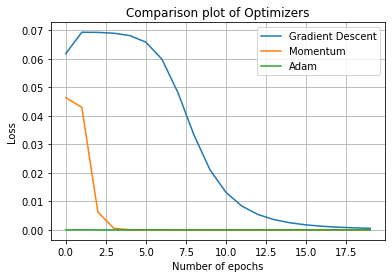

In [9]:
# Ploting the graph between loss vs epochs for all 3 optimizers.
import matplotlib.pyplot as plt
e=[i for i in range(epochs)]
plt.plot(e,gd,label='Gradient Descent')
plt.plot(e,momentum,label='Momentum')
plt.plot(e,adam,label='Adam')
plt.title('Comparison plot of Optimizers')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()